/home/aml334/CSE_MSE_RXF131/cradle-members/mds3/aml334/plane-registration/tslearn_env/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Loading and preprocessing 100 segments...


Loading initial segments: 100%|██████████| 100/100 [00:00<00:00, 212.99it/s]

Debug: Found 1384 starts and 1383 ends
First few starts: [8579, 8931, 9381, 9901, 10480]
First few ends: [8755, 9210, 9733, 10313, 10943]
Found 100 initial segments
Segment shape after padding: (100, 500, 2)
Trying multiple clustering approaches...
1. Standard TimeSeriesKMeans with DTW


DTW clustering completed. Unique labels: (array([0, 1, 2, 3]), array([ 1, 46, 40, 13]))
2. TimeSeriesKMeans with Euclidean distance
Euclidean clustering completed. Unique labels: (array([0, 1, 2, 3]), array([12, 21, 25, 42]))
3. TimeSeriesKMeans with Soft-DTW


/home/aml334/CSE_MSE_RXF131/cradle-members/mds3/aml334/plane-registration/tslearn_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Soft-DTW clustering completed. Unique labels: (array([0, 1, 2, 3]), array([15, 38, 30, 17]))
DTW: 4 unique clusters
Euclidean: 4 unique clusters
Soft-DTW: 4 unique clusters
Selected DTW as the best model


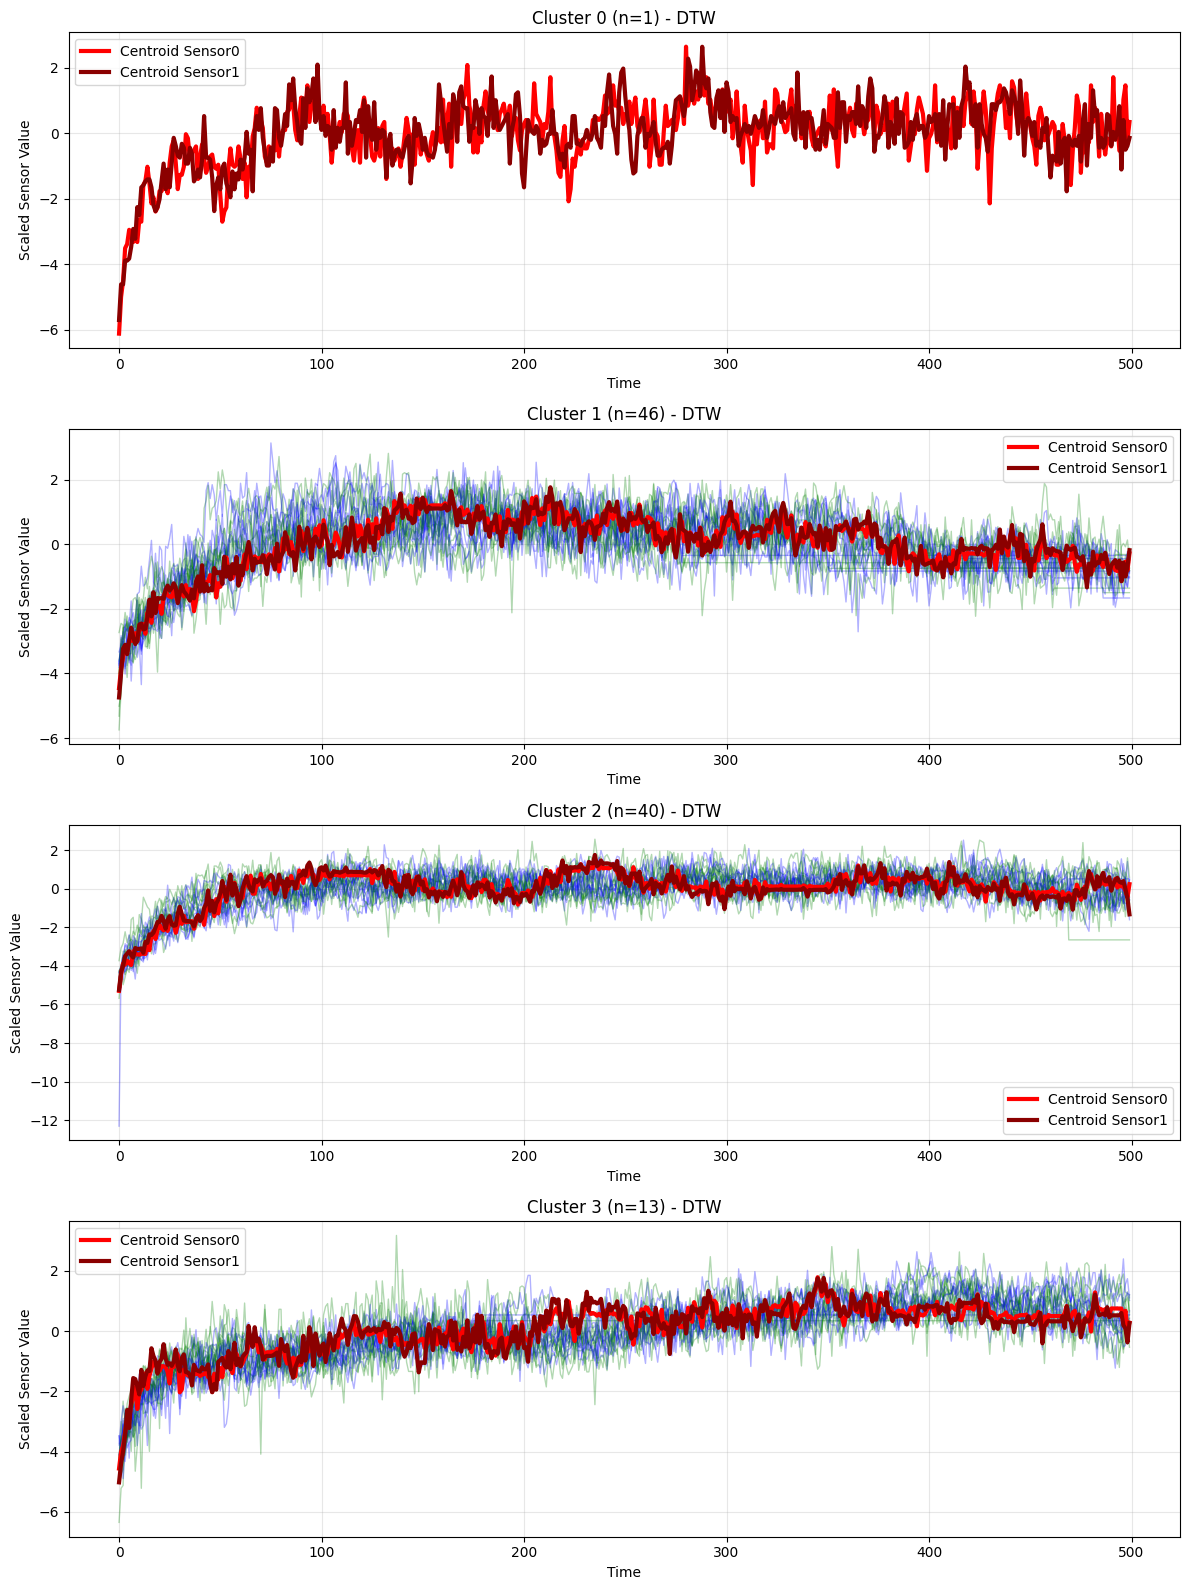

Clustering Validation Metrics:
Silhouette Score: 0.039 (higher is better, range: -1 to 1)
Calinski-Harabasz Score: 5.146 (higher is better)
Cluster distribution: {np.int64(0): np.int64(1), np.int64(1): np.int64(46), np.int64(2): np.int64(40), np.int64(3): np.int64(13)}


In [ ]:
# %%

import tslearn
import tslearn.preprocessing
import tslearn.clustering
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow.parquet as pq
import os
import warnings
from tqdm import tqdm
import argparse
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings("ignore", message=".*force_all_finite.*")

def segment_df(df: pl.DataFrame) -> list[pl.DataFrame]:
    """Extract segments where state0 transitions from 0 to 1 and back to 0"""
    df = df.with_columns([
        pl.col('state0').shift(1).alias('state0_prev'),
    ])
    df = df.with_columns([
        ((pl.col('state0_prev') == 0) & (pl.col('state0') == 1)).alias('is_start'),
        ((pl.col('state0_prev') == 1) & (pl.col('state0') == 0)).alias('is_end'),
    ])

    # Get row indices where transitions occur
    df_with_index = df.with_row_index()
    
    # Get indices of starts and ends
    starts = df_with_index.filter(pl.col('is_start')).select('index').to_series().to_list()
    ends = df_with_index.filter(pl.col('is_end')).select('index').to_series().to_list()
    
    print(f"Debug: Found {len(starts)} starts and {len(ends)} ends")
    if starts:
        print(f"First few starts: {starts[:5]}")
    if ends:
        print(f"First few ends: {ends[:5]}")

    segments = []
    for start in starts:
        # Find the first end after this start
        end = next((e for e in ends if e > start), None)
        if end:
            segment = df[start:end].select(['sensor0', 'sensor1'])
            # Only include segments with minimum length
            if len(segment) >= 10:  # Minimum segment length
                segments.append(segment)

    return segments

def load_parquet_segments(full_paths, max_segments=None):
    """Generator to load segments from parquet files"""
    segment_count = 0
    for path in full_paths:
        if max_segments and segment_count >= max_segments:
            break
        try:
            stream_file = pq.ParquetFile(path)
            for group_index in range(stream_file.num_row_groups):
                if max_segments and segment_count >= max_segments:
                    break
                df = pl.from_arrow(stream_file.read_row_group(group_index))
                for segment in segment_df(df):
                    if max_segments and segment_count >= max_segments:
                        break
                    yield segment
                    segment_count += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

def pad_or_truncate_segments(segments, target_length=100):
    """Ensure all segments have the same length for clustering"""
    processed_segments = []
    
    for segment in segments:
        # Convert to numpy array
        if isinstance(segment, pl.DataFrame):
            data = segment.to_numpy()
        else:
            data = np.array(segment)
        
        current_length = len(data)
        
        if current_length > target_length:
            # Truncate
            data = data[:target_length]
        elif current_length < target_length:
            # Pad with last value
            last_values = data[-1:] if len(data) > 0 else np.zeros((1, data.shape[1]))
            padding = np.repeat(last_values, target_length - current_length, axis=0)
            data = np.vstack([data, padding])
        
        processed_segments.append(data)
    
    return np.array(processed_segments)

def improved_clustering_approach(parquet_directory, n_segments, n_clusters, target_length):
    """Improved clustering approach with better initialization and validation"""
    
    # Get parquet files
    parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith(".parquet")]
    full_paths = [os.path.join(parquet_directory, f) for f in parquet_files]
    
    print(f"Loading and preprocessing {n_segments} segments...")
    
    # Collect segments for initial clustering
    initial_segments = []
    segment_generator = load_parquet_segments(full_paths, max_segments=min(1000, n_segments))
    
    for segment in tqdm(segment_generator, desc="Loading initial segments", total=min(1000, n_segments)):
        initial_segments.append(segment)
    
    if len(initial_segments) == 0:
        raise ValueError("No segments found in the data")
    
    print(f"Found {len(initial_segments)} initial segments")
    
    # Pad/truncate to consistent length
    X_initial = pad_or_truncate_segments(initial_segments, target_length)
    print(f"Segment shape after padding: {X_initial.shape}")
    
    # Scale the data
    scaler = tslearn.preprocessing.TimeSeriesScalerMeanVariance()
    X_initial_scaled = scaler.fit_transform(X_initial)
    
    # Try different clustering approaches
    print("Trying multiple clustering approaches...")
    
    # Approach 1: Standard TimeSeriesKMeans
    print("1. Standard TimeSeriesKMeans with DTW")
    model_dtw = tslearn.clustering.TimeSeriesKMeans(
        n_clusters=n_clusters, 
        metric="dtw", 
        max_iter=20, 
        random_state=42,
        n_init=3
    )
    
    try:
        labels_dtw = model_dtw.fit_predict(X_initial_scaled)
        print(f"DTW clustering completed. Unique labels: {np.unique(labels_dtw, return_counts=True)}")
    except Exception as e:
        print(f"DTW clustering failed: {e}")
        model_dtw = None
    
    # Approach 2: Euclidean distance (faster, might work better for some data)
    print("2. TimeSeriesKMeans with Euclidean distance")
    model_euclidean = tslearn.clustering.TimeSeriesKMeans(
        n_clusters=n_clusters, 
        metric="euclidean", 
        max_iter=20, 
        random_state=42,
        n_init=5
    )
    
    try:
        labels_euclidean = model_euclidean.fit_predict(X_initial_scaled)
        print(f"Euclidean clustering completed. Unique labels: {np.unique(labels_euclidean, return_counts=True)}")
    except Exception as e:
        print(f"Euclidean clustering failed: {e}")
        model_euclidean = None
    
    # Approach 3: Soft-DTW (if available and data is suitable)
    print("3. TimeSeriesKMeans with Soft-DTW")
    try:
        model_soft_dtw = tslearn.clustering.TimeSeriesKMeans(
            n_clusters=n_clusters, 
            metric="softdtw", 
            max_iter=10, 
            random_state=42,
            n_init=2
        )
        labels_soft_dtw = model_soft_dtw.fit_predict(X_initial_scaled)
        print(f"Soft-DTW clustering completed. Unique labels: {np.unique(labels_soft_dtw, return_counts=True)}")
    except Exception as e:
        print(f"Soft-DTW clustering failed: {e}")
        model_soft_dtw = None
    
    # Choose the best model (one that actually creates multiple clusters)
    models = [
        ("DTW", model_dtw, labels_dtw if model_dtw else None),
        ("Euclidean", model_euclidean, labels_euclidean if model_euclidean else None),
        ("Soft-DTW", model_soft_dtw, labels_soft_dtw if model_soft_dtw else None)
    ]
    
    best_model = None
    best_labels = None
    best_name = None
    
    for name, model, labels in models:
        if model is not None and labels is not None:
            n_unique_clusters = len(np.unique(labels))
            print(f"{name}: {n_unique_clusters} unique clusters")
            if n_unique_clusters > 1 and (best_model is None or n_unique_clusters > len(np.unique(best_labels))):
                best_model = model
                best_labels = labels
                best_name = name
    
    if best_model is None:
        raise ValueError("All clustering approaches failed")
    
    print(f"Selected {best_name} as the best model")
    
    # Visualize results
    plot_clustering_results(X_initial_scaled, best_labels, best_model, best_name)
    
    return best_model, scaler, best_labels, X_initial_scaled

def plot_clustering_results(X_data, labels, model, method_name):
    """Plot clustering results"""
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters))
    
    if n_clusters == 1:
        axes = [axes]
    
    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]
        
        # Get time series for this cluster
        cluster_mask = labels == cluster_idx
        cluster_ts = X_data[cluster_mask]
        
        # Plot sample time series (max 10 for visibility)
        n_samples = min(10, len(cluster_ts))
        for i in range(n_samples):
            # Plot both sensors
            ax.plot(cluster_ts[i, :, 0], alpha=0.3, color='blue', linewidth=1)
            if cluster_ts.shape[2] > 1:  # If we have sensor1
                ax.plot(cluster_ts[i, :, 1], alpha=0.3, color='green', linewidth=1)
        
        # Plot centroid if available
        try:
            centroid = model.cluster_centers_[cluster_idx]
            ax.plot(centroid[:, 0], color='red', linewidth=3, label='Centroid Sensor0')
            if centroid.shape[1] > 1:
                ax.plot(centroid[:, 1], color='darkred', linewidth=3, label='Centroid Sensor1')
        except:
            pass
        
        ax.set_title(f'Cluster {cluster_idx} (n={np.sum(cluster_mask)}) - {method_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Scaled Sensor Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def validate_clustering(X_data, labels, model):
    """Validate clustering results"""
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    
    # Flatten data for sklearn metrics
    X_flat = X_data.reshape(X_data.shape[0], -1)
    
    try:
        sil_score = silhouette_score(X_flat, labels)
        ch_score = calinski_harabasz_score(X_flat, labels)
        
        print(f"Clustering Validation Metrics:")
        print(f"Silhouette Score: {sil_score:.3f} (higher is better, range: -1 to 1)")
        print(f"Calinski-Harabasz Score: {ch_score:.3f} (higher is better)")
        
        # Check cluster distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"Cluster distribution: {dict(zip(unique_labels, counts))}")
        
        return sil_score, ch_score
    except Exception as e:
        print(f"Validation failed: {e}")
        return None, None

# Example usage for your environment:
if __name__ == "__main__":
    # Use your existing parameters instead of argparse
    parquet_directory = "/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/aconity_parquet/"
    n_segments = 100  # Start smaller for testing
    n_clusters = 4
    target_length = 500
    
    try:
        model, scaler, labels, X_data = improved_clustering_approach(
            parquet_directory, 
            n_segments, 
            n_clusters, 
            target_length
        )
        
        # Validate the results
        validate_clustering(X_data, labels, model)
        
    except Exception as e:
        print(f"Clustering failed: {e}")
        print("Consider:")
        print("1. Reducing the number of clusters")
        print("2. Checking data quality and segment extraction")
        print("3. Trying different preprocessing approaches")

Loading and preprocessing 100 segments...


Loading initial segments: 100%|██████████| 100/100 [00:00<00:00, 676.23it/s]

Debug: Found 1383 starts and 1384 ends
First few starts: [8755, 9210, 9733, 10313, 10943]
First few ends: [8579, 8931, 9381, 9901, 10480]
Found 100 initial segments
Segment shape after padding: (100, 500, 2)
Trying multiple clustering approaches...
1. Standard TimeSeriesKMeans with DTW


DTW clustering completed. Unique labels: (array([0, 1, 2, 3]), array([34,  6, 23, 37]))
2. TimeSeriesKMeans with Euclidean distance
Euclidean clustering completed. Unique labels: (array([0, 1, 2, 3]), array([32, 35, 25,  8]))
3. TimeSeriesKMeans with Soft-DTW
Soft-DTW clustering completed. Unique labels: (array([0, 1, 2, 3]), array([42,  9, 31, 18]))
DTW: 4 unique clusters
Euclidean: 4 unique clusters
Soft-DTW: 4 unique clusters
Selected DTW as the best model


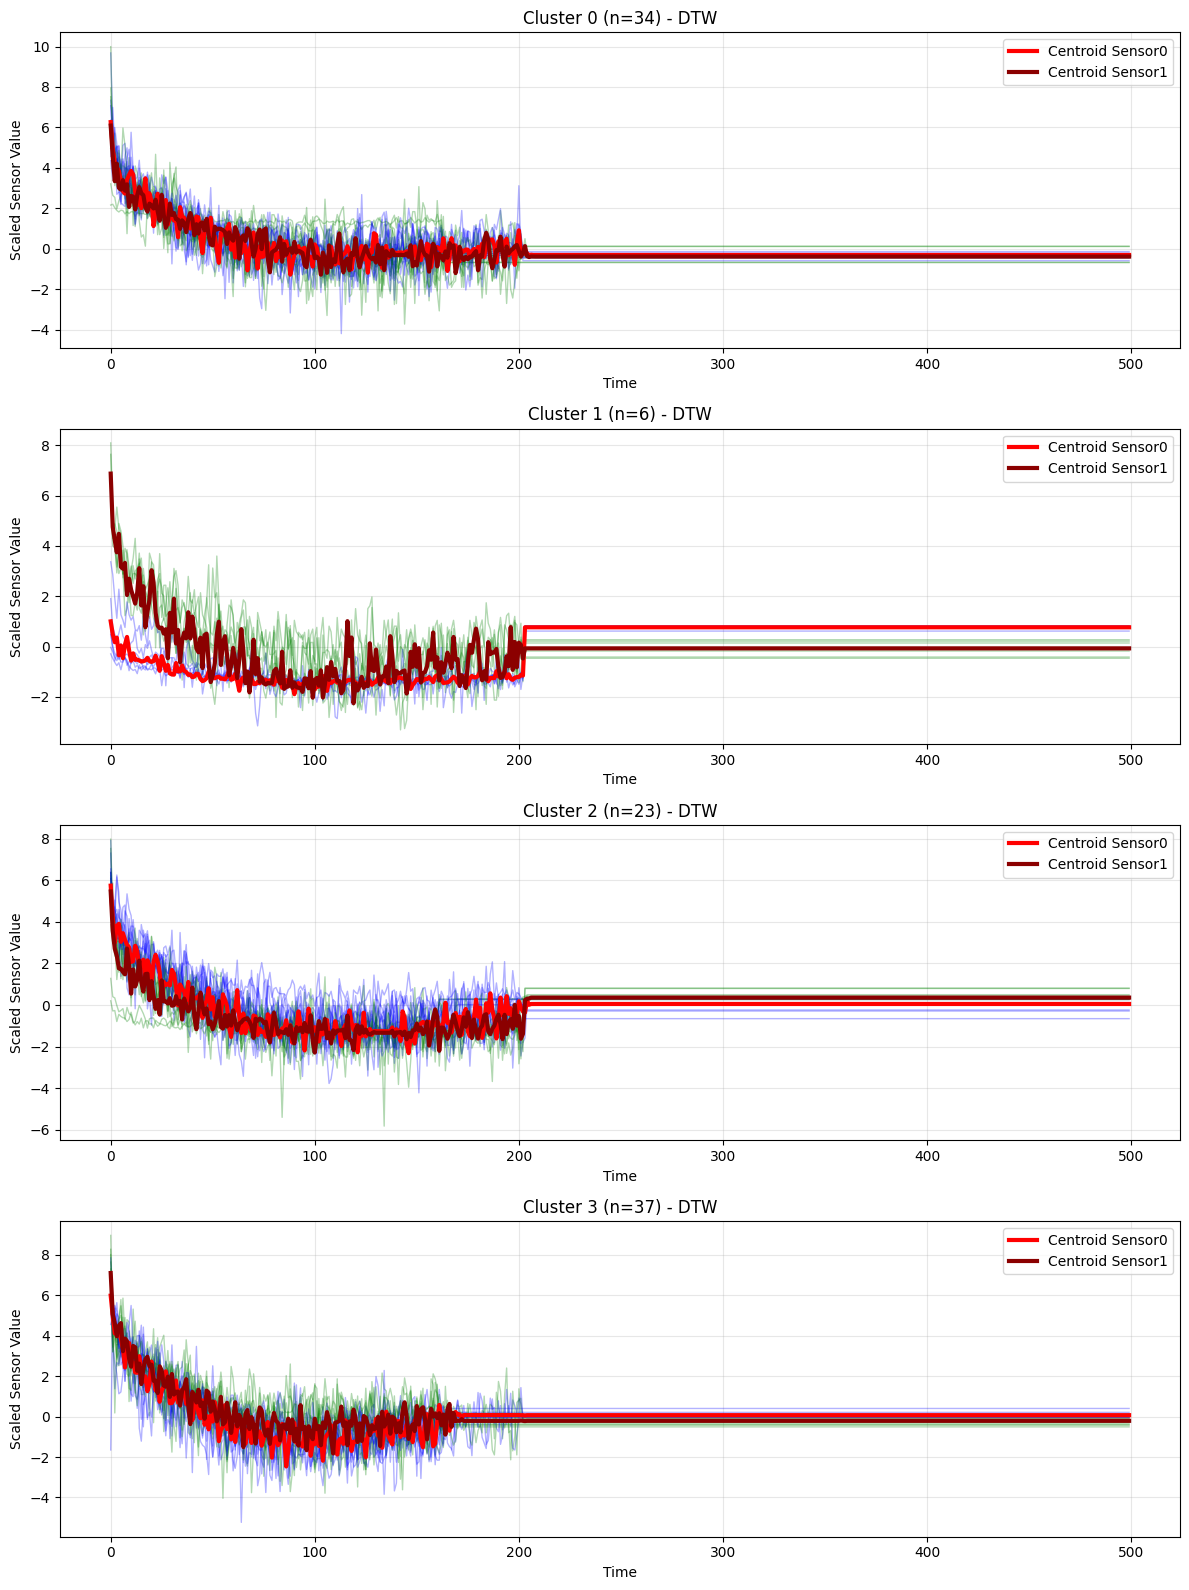

Clustering Validation Metrics:
Silhouette Score: 0.103 (higher is better, range: -1 to 1)
Calinski-Harabasz Score: 14.052 (higher is better)
Cluster distribution: {np.int64(0): np.int64(34), np.int64(1): np.int64(6), np.int64(2): np.int64(23), np.int64(3): np.int64(37)}


In [ ]:
# %%

import tslearn
import tslearn.preprocessing
import tslearn.clustering
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow.parquet as pq
import os
import warnings
from tqdm import tqdm
import argparse
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings("ignore", message=".*force_all_finite.*")

def segment_df(df: pl.DataFrame) -> list[pl.DataFrame]:
    """Extract segments where state0 transitions from 0 to 1 and back to 0"""
    df = df.with_columns([
        pl.col('state0').shift(1).alias('state0_prev'),
    ])
    df = df.with_columns([
        ((pl.col('state0_prev') == 0) & (pl.col('state0') == 1)).alias('is_end'),
        ((pl.col('state0_prev') == 1) & (pl.col('state0') == 0)).alias('is_start'),
    ])

    # Get row indices where transitions occur
    df_with_index = df.with_row_index()
    
    # Get indices of starts and ends
    starts = df_with_index.filter(pl.col('is_start')).select('index').to_series().to_list()
    ends = df_with_index.filter(pl.col('is_end')).select('index').to_series().to_list()
    
    print(f"Debug: Found {len(starts)} starts and {len(ends)} ends")
    if starts:
        print(f"First few starts: {starts[:5]}")
    if ends:
        print(f"First few ends: {ends[:5]}")

    segments = []
    for start in starts:
        # Find the first end after this start
        end = next((e for e in ends if e > start), None)
        if end:
            segment = df[start:end].select(['sensor0', 'sensor1'])
            # Only include segments with minimum length
            if len(segment) >= 10:  # Minimum segment length
                segments.append(segment)

    return segments

def load_parquet_segments(full_paths, max_segments=None):
    """Generator to load segments from parquet files"""
    segment_count = 0
    for path in full_paths:
        if max_segments and segment_count >= max_segments:
            break
        try:
            stream_file = pq.ParquetFile(path)
            for group_index in range(stream_file.num_row_groups):
                if max_segments and segment_count >= max_segments:
                    break
                df = pl.from_arrow(stream_file.read_row_group(group_index))
                for segment in segment_df(df):
                    if max_segments and segment_count >= max_segments:
                        break
                    yield segment
                    segment_count += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

def pad_or_truncate_segments(segments, target_length=100):
    """Ensure all segments have the same length for clustering"""
    processed_segments = []
    
    for segment in segments:
        # Convert to numpy array
        if isinstance(segment, pl.DataFrame):
            data = segment.to_numpy()
        else:
            data = np.array(segment)
        
        current_length = len(data)
        
        if current_length > target_length:
            # Truncate
            data = data[:target_length]
        elif current_length < target_length:
            # Pad with last value
            last_values = data[-1:] if len(data) > 0 else np.zeros((1, data.shape[1]))
            padding = np.repeat(last_values, target_length - current_length, axis=0)
            data = np.vstack([data, padding])
        
        processed_segments.append(data)
    
    return np.array(processed_segments)

def improved_clustering_approach(parquet_directory, n_segments, n_clusters, target_length):
    """Improved clustering approach with better initialization and validation"""
    
    # Get parquet files
    parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith(".parquet")]
    full_paths = [os.path.join(parquet_directory, f) for f in parquet_files]
    
    print(f"Loading and preprocessing {n_segments} segments...")
    
    # Collect segments for initial clustering
    initial_segments = []
    segment_generator = load_parquet_segments(full_paths, max_segments=min(1000, n_segments))
    
    for segment in tqdm(segment_generator, desc="Loading initial segments", total=min(1000, n_segments)):
        initial_segments.append(segment)
    
    if len(initial_segments) == 0:
        raise ValueError("No segments found in the data")
    
    print(f"Found {len(initial_segments)} initial segments")
    
    # Pad/truncate to consistent length
    X_initial = pad_or_truncate_segments(initial_segments, target_length)
    print(f"Segment shape after padding: {X_initial.shape}")
    
    # Scale the data
    scaler = tslearn.preprocessing.TimeSeriesScalerMeanVariance()
    X_initial_scaled = scaler.fit_transform(X_initial)
    
    # Try different clustering approaches
    print("Trying multiple clustering approaches...")
    
    # Approach 1: Standard TimeSeriesKMeans
    print("1. Standard TimeSeriesKMeans with DTW")
    model_dtw = tslearn.clustering.TimeSeriesKMeans(
        n_clusters=n_clusters, 
        metric="dtw", 
        max_iter=20, 
        random_state=42,
        n_init=3
    )
    
    try:
        labels_dtw = model_dtw.fit_predict(X_initial_scaled)
        print(f"DTW clustering completed. Unique labels: {np.unique(labels_dtw, return_counts=True)}")
    except Exception as e:
        print(f"DTW clustering failed: {e}")
        model_dtw = None
    
    # Approach 2: Euclidean distance (faster, might work better for some data)
    print("2. TimeSeriesKMeans with Euclidean distance")
    model_euclidean = tslearn.clustering.TimeSeriesKMeans(
        n_clusters=n_clusters, 
        metric="euclidean", 
        max_iter=20, 
        random_state=42,
        n_init=5
    )
    
    try:
        labels_euclidean = model_euclidean.fit_predict(X_initial_scaled)
        print(f"Euclidean clustering completed. Unique labels: {np.unique(labels_euclidean, return_counts=True)}")
    except Exception as e:
        print(f"Euclidean clustering failed: {e}")
        model_euclidean = None
    
    # Approach 3: Soft-DTW (if available and data is suitable)
    print("3. TimeSeriesKMeans with Soft-DTW")
    try:
        model_soft_dtw = tslearn.clustering.TimeSeriesKMeans(
            n_clusters=n_clusters, 
            metric="softdtw", 
            max_iter=10, 
            random_state=42,
            n_init=2
        )
        labels_soft_dtw = model_soft_dtw.fit_predict(X_initial_scaled)
        print(f"Soft-DTW clustering completed. Unique labels: {np.unique(labels_soft_dtw, return_counts=True)}")
    except Exception as e:
        print(f"Soft-DTW clustering failed: {e}")
        model_soft_dtw = None
    
    # Choose the best model (one that actually creates multiple clusters)
    models = [
        ("DTW", model_dtw, labels_dtw if model_dtw else None),
        ("Euclidean", model_euclidean, labels_euclidean if model_euclidean else None),
        ("Soft-DTW", model_soft_dtw, labels_soft_dtw if model_soft_dtw else None)
    ]
    
    best_model = None
    best_labels = None
    best_name = None
    
    for name, model, labels in models:
        if model is not None and labels is not None:
            n_unique_clusters = len(np.unique(labels))
            print(f"{name}: {n_unique_clusters} unique clusters")
            if n_unique_clusters > 1 and (best_model is None or n_unique_clusters > len(np.unique(best_labels))):
                best_model = model
                best_labels = labels
                best_name = name
    
    if best_model is None:
        raise ValueError("All clustering approaches failed")
    
    print(f"Selected {best_name} as the best model")
    
    # Visualize results
    plot_clustering_results(X_initial_scaled, best_labels, best_model, best_name)
    
    return best_model, scaler, best_labels, X_initial_scaled

def plot_clustering_results(X_data, labels, model, method_name):
    """Plot clustering results"""
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters))
    
    if n_clusters == 1:
        axes = [axes]
    
    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]
        
        # Get time series for this cluster
        cluster_mask = labels == cluster_idx
        cluster_ts = X_data[cluster_mask]
        
        # Plot sample time series (max 10 for visibility)
        n_samples = min(10, len(cluster_ts))
        for i in range(n_samples):
            # Plot both sensors
            ax.plot(cluster_ts[i, :, 0], alpha=0.3, color='blue', linewidth=1)
            if cluster_ts.shape[2] > 1:  # If we have sensor1
                ax.plot(cluster_ts[i, :, 1], alpha=0.3, color='green', linewidth=1)
        
        # Plot centroid if available
        try:
            centroid = model.cluster_centers_[cluster_idx]
            ax.plot(centroid[:, 0], color='red', linewidth=3, label='Centroid Sensor0')
            if centroid.shape[1] > 1:
                ax.plot(centroid[:, 1], color='darkred', linewidth=3, label='Centroid Sensor1')
        except:
            pass
        
        ax.set_title(f'Cluster {cluster_idx} (n={np.sum(cluster_mask)}) - {method_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Scaled Sensor Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def validate_clustering(X_data, labels, model):
    """Validate clustering results"""
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    
    # Flatten data for sklearn metrics
    X_flat = X_data.reshape(X_data.shape[0], -1)
    
    try:
        sil_score = silhouette_score(X_flat, labels)
        ch_score = calinski_harabasz_score(X_flat, labels)
        
        print(f"Clustering Validation Metrics:")
        print(f"Silhouette Score: {sil_score:.3f} (higher is better, range: -1 to 1)")
        print(f"Calinski-Harabasz Score: {ch_score:.3f} (higher is better)")
        
        # Check cluster distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"Cluster distribution: {dict(zip(unique_labels, counts))}")
        
        return sil_score, ch_score
    except Exception as e:
        print(f"Validation failed: {e}")
        return None, None

# Example usage for your environment:
if __name__ == "__main__":
    # Use your existing parameters instead of argparse
    parquet_directory = "/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/aconity_parquet/"
    n_segments = 100  # Start smaller for testing
    n_clusters = 4
    target_length = 500
    
    try:
        model, scaler, labels, X_data = improved_clustering_approach(
            parquet_directory, 
            n_segments, 
            n_clusters, 
            target_length
        )
        
        # Validate the results
        validate_clustering(X_data, labels, model)
        
    except Exception as e:
        print(f"Clustering failed: {e}")
        print("Consider:")
        print("1. Reducing the number of clusters")
        print("2. Checking data quality and segment extraction")
        print("3. Trying different preprocessing approaches")